In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Import Dataframe

In [2]:
df=pd.read_csv('AirQualityUCI.csv',sep=';')
df.drop(df[(df['PT08.S1(CO)'] == -200)].index, inplace=True)

In [3]:
torch.manual_seed(111)

num=1024

col1 = df['PT08.S1(CO)'].values
col2 = df['NMHC(GT)'].values

array1 = np.zeros(num)
array2 = np.zeros(num)
for i in range(num):
    array1[i] = col1[i]
    array2[i] = col2[i]

train_data_length = num
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.from_numpy(array1)
train_data[:, 1] = torch.from_numpy(array2)
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
# Define batch size for the data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Discriminator and Generator

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [6]:
# Define learning rate, number of epoch and type of loss function
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [7]:
for epoch in range(num_epochs):

    for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator

        real_samples_labels = torch.ones((batch_size, 1))

        latent_space_samples = torch.randn((batch_size, 2))

        generated_samples = generator(latent_space_samples)

        generated_samples_labels = torch.zeros((batch_size, 1))

        all_samples = torch.cat((real_samples, generated_samples))

        all_samples_labels = torch.cat(

            (real_samples_labels, generated_samples_labels)

        )


        # Training the discriminator

        discriminator.zero_grad()

        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(

            output_discriminator, all_samples_labels)

        loss_discriminator.backward()

        optimizer_discriminator.step()


        # Data for training the generator

        latent_space_samples = torch.randn((batch_size, 2))


        # Training the generator

        generator.zero_grad()

        generated_samples = generator(latent_space_samples)

        output_discriminator_generated = discriminator(generated_samples)

        loss_generator = loss_function(

            output_discriminator_generated, real_samples_labels

        )

        loss_generator.backward()

        optimizer_generator.step()


        # Show loss

        if epoch % 10 == 0 and n == batch_size - 1:

            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")

            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.11712616682052612
Epoch: 0 Loss G.: 1.683789610862732
Epoch: 10 Loss D.: 0.21443665027618408
Epoch: 10 Loss G.: 1.8583934307098389
Epoch: 20 Loss D.: 0.280499130487442
Epoch: 20 Loss G.: 1.1008493900299072
Epoch: 30 Loss D.: 0.21810802817344666
Epoch: 30 Loss G.: 1.1805723905563354
Epoch: 40 Loss D.: 0.20646286010742188
Epoch: 40 Loss G.: 1.1448601484298706
Epoch: 50 Loss D.: 0.236850768327713
Epoch: 50 Loss G.: 1.2456995248794556
Epoch: 60 Loss D.: 0.3000245690345764
Epoch: 60 Loss G.: 1.352338433265686
Epoch: 70 Loss D.: 0.2902470827102661
Epoch: 70 Loss G.: 1.518498182296753
Epoch: 80 Loss D.: 0.4215327203273773
Epoch: 80 Loss G.: 1.4509748220443726
Epoch: 90 Loss D.: 0.24152198433876038
Epoch: 90 Loss G.: 1.7670005559921265
Epoch: 100 Loss D.: 0.4738338589668274
Epoch: 100 Loss G.: 1.4525707960128784
Epoch: 110 Loss D.: 0.5564954876899719
Epoch: 110 Loss G.: 1.305614709854126
Epoch: 120 Loss D.: 0.5004066228866577
Epoch: 120 Loss G.: 1.0563369989395142
Epoch: 13

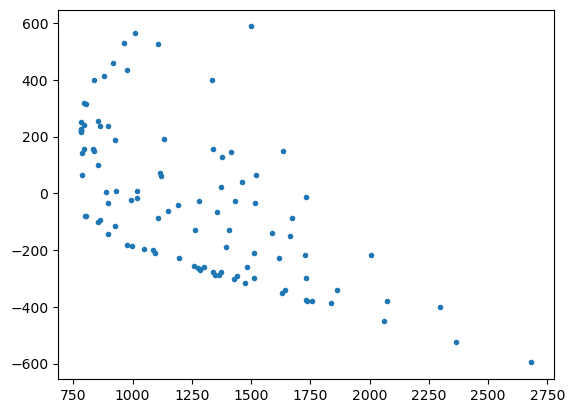

In [8]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")